In [1]:
import numpy as np
import nibabel as nib
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.transform as skTrans
import math

In [2]:
rootDirPath = "..\\mmwhs\\ct_train\\"

In [3]:
def CreateSaggitalUnet(x, y, channel, num_classes=8):

    # [slice, :, :]
    inputs = tf.keras.layers.Input((x, y, channel))
    kernel_initializer = "he_normal"

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.PReLU()(p1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.PReLU()(p2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.PReLU()(p3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = tf.keras.layers.PReLU()(p4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.PReLU()(u6)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.PReLU()(u7)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.PReLU()(u8)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.PReLU()(u9)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [4]:
def CreateCoronalUnet(x, y, channel, num_classes=8):

    # [:, slice, :]
    inputs = tf.keras.layers.Input((x, y, channel))
    kernel_initializer = "he_normal"

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.PReLU()(p1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.PReLU()(p2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.PReLU()(p3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = tf.keras.layers.PReLU()(p4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.PReLU()(u6)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.PReLU()(u7)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.PReLU()(u8)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.PReLU()(u9)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [3]:
def CreateAxialUnet(x, y, channel, num_classes=8):
    # [:, :, slice]
    inputs = tf.keras.layers.Input((x, y, channel))
    kernel_initializer = "he_normal"

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.PReLU()(p1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.PReLU()(p2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.PReLU()(p3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = tf.keras.layers.PReLU()(p4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.PReLU()(u6)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.PReLU()(u7)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.PReLU()(u8)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.PReLU()(u9)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [19]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, num_classes):
    kernel_initializer = 'he_uniform'  # Try others if you want
    # Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    return model

In [3]:
def OneHotEncode2D(original, x_, y_, num_classes=8):
    encodeList = {
        0: 0,
        500: 1,
        600: 2,
        420: 3,
        550: 4,
        205: 5,
        820: 6,
        850: 7,
    }

    x, y = original.shape

    labelEncode = np.empty((x_, y_, num_classes), dtype="float16")
    for i_ in range(x_):
        for j_ in range(y_):
            i = math.floor( (i_ * x) / x_)
            j = math.floor( (j_ * y) / y_)

            i = max(0, min(i, x - 1))
            j = max(0, min(j, y - 1))

            value = original[i][j]

            encodeIndex = encodeList[value]

            for n in range(8):
                labelEncode[i_][j_][n] = 0

            labelEncode[i_][j_][encodeIndex] = 1

    return labelEncode

def ResizeImage(image, x_, y_):
  return np.array(skTrans.resize(image, (x_, y_), order=1, preserve_range=True, anti_aliasing=False), dtype="float16")

In [4]:
def NormalizeImageIntensityRange(image):
  houndsfieldMax = 2000
  houndsfieldMin = -1000
  image[image < houndsfieldMin] = houndsfieldMin
  image[image > houndsfieldMax] = houndsfieldMax

  # min max intensity normalization with houndsfield
  return (image - houndsfieldMin) / (houndsfieldMax - houndsfieldMin)

In [9]:
def GenerateData(start, stop, rootDirPath, viewpoint):
  def SortImageKey(filename):
    parts = filename.split('_')
    return (int(parts[2]), parts[3])

  x = []
  y = []
  pathList = sorted(os.listdir(rootDirPath), key=SortImageKey)

  for f in range(start, stop, 2):
    image = np.array(nib.load(os.path.join(rootDirPath, pathList[f])).get_fdata(), dtype="float16")
    label = np.array(nib.load(os.path.join(rootDirPath, pathList[f + 1])).get_fdata(), dtype="float16")
    for i in range(image.shape[viewpoint - 1]):
      if viewpoint == 1:
        newImage = image[i, :, :]
        newImage = ResizeImage(newImage, 256, 256)
        newImage = NormalizeImageIntensityRange(newImage)
        newImage = np.expand_dims(newImage, -1)

        newLabel = label[i, :, :]
        newLabel = OneHotEncode2D(newLabel, 256, 256)

        x.append(newImage)
        y.append(newLabel)

      elif viewpoint == 2:
        newImage = image[:, i, :]
        newImage = ResizeImage(newImage, 256, 256)
        newImage = NormalizeImageIntensityRange(newImage)
        newImage = np.expand_dims(newImage, -1)

        newLabel = label[:, i, :]
        newLabel = OneHotEncode2D(newLabel, 256, 256)

        x.append(newImage)
        y.append(newLabel)

      elif viewpoint == 3:
        newImage = image[:, :, i]
        newImage = ResizeImage(newImage, 256, 256)
        newImage = NormalizeImageIntensityRange(newImage)
        newImage = np.expand_dims(newImage, -1)

        newLabel = label[:, :, i]
        newLabel = OneHotEncode2D(newLabel, 256, 256)

        x.append(newImage)
        y.append(newLabel)

  x = np.array(x)
  y = np.array(y)
  return x, y

In [6]:
def GenerateFullResData(start, stop, rootDirPath):
  def SortImageKey(filename):
    parts = filename.split('_')
    return (int(parts[2]), parts[3])

  x = []
  y = []
  pathList = sorted(os.listdir(rootDirPath), key=SortImageKey)

  for f in range(start, stop, 2):
    image = np.array(nib.load(os.path.join(
        rootDirPath, pathList[f])).get_fdata(), dtype="float16")
    label = np.array(nib.load(os.path.join(
        rootDirPath, pathList[f + 1])).get_fdata(), dtype="float16")
    for i in range(image.shape[-1]):
        
        newImage = image[:, :, i]
        newImage = NormalizeImageIntensityRange(newImage)
        newImage = np.expand_dims(newImage, -1)

        newLabel = label[:, :, i]
        newLabel = OneHotEncode2D(newLabel, 512, 512)

        x.append(newImage)
        y.append(newLabel)

  x = np.array(x)
  y = np.array(y)
  return x, y

In [7]:
x_axial_full_res, y_axial_full_res = GenerateFullResData(0, 30, rootDirPath)

MemoryError: Unable to allocate 15.0 GiB for an array with shape (3842, 512, 512, 8) and data type float16

In [5]:
x = np.load("./x_axial.npy")
print(x.shape)

(3842, 256, 256, 1)


In [6]:
y = np.load("./y_axial.npy")
print(y.shape)

(3842, 256, 256, 8)


In [36]:
def TrainingLoop(model, originalX, originalY):
  x = []
  y = []
  trainingHistory = {}

  for i in range(0, 15, 5):
    x.append(originalX[i])
    x.append(originalX[i + 1])
    x.append(originalX[i + 2])
    x.append(originalX[i + 3])
    x.append(originalX[i + 4])

    y.append(originalY[i])
    y.append(originalY[i + 1])
    y.append(originalY[i + 2])
    y.append(originalY[i + 3])
    y.append(originalY[i + 4])

    x = np.array(x)
    y = np.array(y)

    print(f"Image: {x.shape}")
    print(f"Label: {y.shape}")

    history = model.fit(x, y, epochs=3, validation_split=0.25)
    for key, value in history.history.items():
      if key not in trainingHistory:
          trainingHistory[key] = []
      trainingHistory[key].extend(value)

    x = []
    y = []

  return trainingHistory

In [58]:
def TrainingLoopWithEvaluate(model, originalX, originalY, validateX, validateY):
  x = []
  y = []
  trainingHistory = {}

  early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_accuracy',
  patience=5,
  restore_best_weights=True
  )

  for i in range(0, 15, 5):
    
    x.append(originalX[i])
    x.append(originalX[i + 1])
    x.append(originalX[i + 2])
    x.append(originalX[i + 3])
    x.append(originalX[i + 4])

    y.append(originalY[i])
    y.append(originalY[i + 1])
    y.append(originalY[i + 2])
    y.append(originalY[i + 3])
    y.append(originalY[i + 4])

    x = np.array(x)
    y = np.array(y)

    print(f"Image: {x.shape}")
    print(f"Label: {y.shape}")

    history = model.fit(x, y, epochs=5, validation_data=(validateX, validateY), callbacks=[early_stopping])
    for key, value in history.history.items():
      if key not in trainingHistory:
          trainingHistory[key] = []
      trainingHistory[key].extend(value)

    x = []
    y = []

  return trainingHistory

In [4]:
xValidate = np.load("./x_axialValidate.npy")
yValidate = np.load("./y_axialValidate.npy")

In [25]:
unetSaggital = CreateSaggitalUnet(256, 256, 1)

In [26]:
trainingHistory = TrainingLoop(unetSaggital, x, y)

Image: (5, 256, 256, 1)
Label: (5, 256, 256, 8)
Epoch 1/4
1/1 [==============================] - 4s 4s/step - loss: 2.0760 - accuracy: 0.2233 - val_loss: 2.0378 - val_accuracy: 0.5360
Epoch 2/4
1/1 [==============================] - 1s 853ms/step - loss: 2.0288 - accuracy: 0.4906 - val_loss: 1.7611 - val_accuracy: 0.3983
Epoch 3/4
1/1 [==============================] - 1s 909ms/step - loss: 1.7324 - accuracy: 0.4082 - val_loss: 1.7331 - val_accuracy: 0.4314
Epoch 4/4
1/1 [==============================] - 1s 865ms/step - loss: 2.2633 - accuracy: 0.4932 - val_loss: 1.2862 - val_accuracy: 0.7790
Image: (5, 256, 256, 1)
Label: (5, 256, 256, 8)
Epoch 1/4
1/1 [==============================] - 1s 979ms/step - loss: 1.1359 - accuracy: 0.7073 - val_loss: 1.4171 - val_accuracy: 0.9756
Epoch 2/4
1/1 [==============================] - 1s 855ms/step - loss: 1.2133 - accuracy: 0.9010 - val_loss: 1.4239 - val_accuracy: 0.9986
Epoch 3/4
1/1 [==============================] - 1s 816ms/step - loss: 1.

In [27]:
unetSaggital.save('.\\trained_model\\unetSaggital.h5', save_format='h5')

e:\isef-vascular\VascuIAR\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
plt.plot(trainingHistory['loss'])
plt.plot(trainingHistory['val_loss'])
plt.title('Saggital Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
plt.plot(trainingHistory['accuracy'])
plt.plot(trainingHistory['val_accuracy'])
plt.title('Saggital Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [31]:
unetCoronal = CreateCoronalUnet(256, 256, 1)

In [32]:
trainingHistoryCoronal = TrainingLoop(unetCoronal, x, y)

Image: (5, 256, 256, 1)
Label: (5, 256, 256, 8)
Epoch 1/4
1/1 [==============================] - 4s 4s/step - loss: 2.0744 - accuracy: 0.6853 - val_loss: 2.0037 - val_accuracy: 0.6981
Epoch 2/4
1/1 [==============================] - 1s 776ms/step - loss: 2.0491 - accuracy: 0.8499 - val_loss: 1.8063 - val_accuracy: 0.6379
Epoch 3/4
1/1 [==============================] - 1s 746ms/step - loss: 1.9635 - accuracy: 0.6254 - val_loss: 1.4239 - val_accuracy: 0.7481
Epoch 4/4
1/1 [==============================] - 1s 745ms/step - loss: 1.7670 - accuracy: 0.6906 - val_loss: 0.8124 - val_accuracy: 0.8817
Image: (5, 256, 256, 1)
Label: (5, 256, 256, 8)
Epoch 1/4
1/1 [==============================] - 1s 768ms/step - loss: 1.2089 - accuracy: 0.8011 - val_loss: 0.8808 - val_accuracy: 0.9964
Epoch 2/4
1/1 [==============================] - 1s 744ms/step - loss: 0.7067 - accuracy: 0.9505 - val_loss: 0.8368 - val_accuracy: 0.9994
Epoch 3/4
1/1 [==============================] - 1s 775ms/step - loss: 0.

In [ ]:
plt.plot(trainingHistoryCoronal['loss'])
plt.plot(trainingHistoryCoronal['val_loss'])
plt.title('Coronal Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
plt.plot(trainingHistoryCoronal['accuracy'])
plt.plot(trainingHistoryCoronal['val_accuracy'])
plt.title('Coronal Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [33]:
unetCoronal.save('.\\trained_model\\unetCoronal.h5', save_format='h5')

In [8]:
xValidate = np.load("./x_axialValidate.npy")
yValidate = np.load("./y_axialValidate.npy")

In [7]:
unetAxial = CreateAxialUnet(256, 256, 1)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
patience=5,
restore_best_weights=True
)

unetAxial.fit(x, y, validation_data=(xValidate, yValidate), callbacks=[early_stopping], epochs=20)

Epoch 1/20
121/121 [==============================] - 703s 6s/step - loss: 0.5066 - accuracy: 0.9030 - val_loss: 0.4091 - val_accuracy: 0.8912
Epoch 2/20


: 

In [57]:
trainingHistoryAxial = TrainingLoopWithEvaluate(unetAxial, x, y, xValidate, yValidate)

Image: (5, 256, 256, 1)
Label: (5, 256, 256, 8)
Epoch 1/5
1/1 [==============================] - 75s 75s/step - loss: 2.1227 - accuracy: 0.4110 - val_loss: 2.1507 - val_accuracy: 0.1961
Epoch 2/5
1/1 [==============================] - 56s 56s/step - loss: 2.0939 - accuracy: 0.8146 - val_loss: 2.0796 - val_accuracy: 0.2435
Epoch 3/5
1/1 [==============================] - 55s 55s/step - loss: 2.0693 - accuracy: 0.8252 - val_loss: 1.9897 - val_accuracy: 0.4342
Epoch 4/5
1/1 [==============================] - 55s 55s/step - loss: 2.0263 - accuracy: 0.8067 - val_loss: 1.7357 - val_accuracy: 0.4899
Epoch 5/5
1/1 [==============================] - 54s 54s/step - loss: 1.9064 - accuracy: 0.6856 - val_loss: 1.9512 - val_accuracy: 0.4948
Image: (5, 256, 256, 1)
Label: (5, 256, 256, 8)
Epoch 1/5
1/1 [==============================] - 58s 58s/step - loss: 1.9660 - accuracy: 0.5985 - val_loss: 1.4405 - val_accuracy: 0.6748
Epoch 2/5
1/1 [==============================] - 53s 53s/step - loss: 1.4588

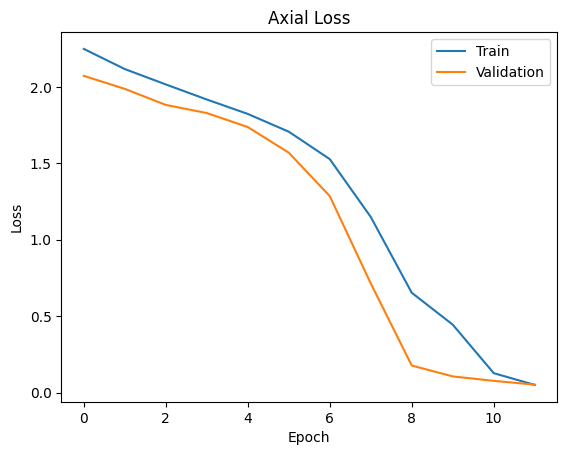

In [88]:
plt.plot(trainingHistoryAxial['loss'])
plt.plot(trainingHistoryAxial['val_loss'])
plt.title('Axial Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


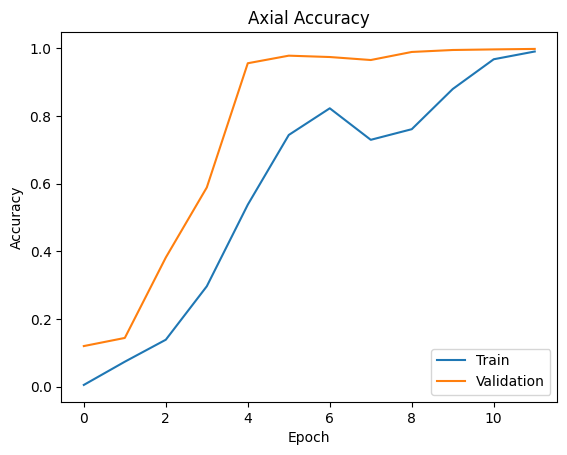

In [87]:
plt.plot(trainingHistoryAxial['accuracy'])
plt.plot(trainingHistoryAxial['val_accuracy'])
plt.title('Axial Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [19]:
unetAxial.save('.\\trained_model\\unetAxial.h5', save_format='h5')

e:\isef-vascular\VascuIAR\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
